In [1]:
!pip install mindvision -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip uninstall opencv-python-headless-4.6.0.66
!pip install "opencv-python-headless<4.3" -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 194 kB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 91.9 MB/s eta 0:00:01
     |████████████████████████████████| 323 kB 39.4 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 29.4 MB/s  eta 0:00:01
     |████████████████████████████████| 55.2 MB 36.7 MB/s eta 0:00:011
     |████████████████████████████████| 49.1 MB 140 kB/s  eta 0:00:01
     |████████████████████████████████| 301 kB 39.3 MB/s eta 0:00:01
     |████████████████████████████████| 701 kB 108.7 MB/s eta 0:00:01
  Created wheel for easydict: filename=easydict-1.10-py3-none-any.whl size=6497 sha256=f2670822081f1fc1f77630293a7ffb74816ff10f9395f370e503f0c4186bf839
  Stored in directory: /root/.cache/pip/wheels/e1/3b/5d/158b57fde5919355b68a33d03e8e141546d8db895644cd683c
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94496 sha256=71861d7712f2987ad85a12a

In [1]:
import os
from mindvision.dataset import DownLoad

#数据集下载路径
dataset_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "./MNIST.zip"
save_dir = "./"

#数据集下载
dl = DownLoad()
if not(os.path.exists(save_dir+"/MNIST.zip")):
    dl.download_and_extract_archive(dataset_url, save_dir)

In [2]:
from mindvision.dataset import Mnist
from mindspore.dataset import MnistDataset
from mindspore import nn, context, ops, Parameter, Tensor
from mindspore.common.initializer import initializer
import numpy as np
context.set_context(device_target='GPU')

# 训练集
dataset_train = MnistDataset(save_dir+"/MNIST/train",shuffle=True) 
# 测试集
dataset_eval = MnistDataset(save_dir+"/MNIST/test",shuffle=True)

In [4]:
import mindspore as ms
from mindspore.dataset import vision, transforms

#数据集处理: datapipe()
def datapipe(dataset, batch_size,usage):
    image_transforms=[
        vision.Resize((32, 32)),
        vision.Rescale(1.0 / 255.0,0),
        vision.ToTensor()
    ]

    label_transform = transforms.TypeCast(ms.int32)
    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)

    return dataset

In [5]:
class ADAM(nn.Optimizer):
    """定义优化器"""
    def __init__(self, parameters, learning_rate, beta1=0.9, beta2=0.999, eps=1e-8):
        super(ADAM, self).__init__(learning_rate, parameters)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        self.beta1_power = Parameter(initializer(1, (), ms.float32), name="beta1_power")
        self.beta2_power = Parameter(initializer(1, (), ms.float32), name="beta2_power")        
        # 初始化动量和学习率调度参数
        self.m = self._parameters.clone(prefix="m", init='zeros')
        self.v = self._parameters.clone(prefix="v", init='zeros')
    
    def construct(self, grads):
        lr = self.get_lr()
        params = self.parameters # 待更新的权重参数
            
        self.beta1_power = self.beta1_power * self.beta1
        self.beta2_power = self.beta2_power * self.beta2
        beta1_correction = 1.0 - self.beta1_power
        beta2_correction = 1.0 - self.beta2_power

        # 更新动量和学习率调度参数
        ops.assign(self.m, (1 - self.beta1) * (self.m - grads))
        ops.assign(self.v, (1 - self.beta2) * (self.v - (grads * grads)))

        # 计算学习率调度
        lr = self.learning_rate * ops.sqrt(beta2_correction) / beta1_correction

        # 更新参数
        ops.assign(params, lr * self.m / (ops.sqrt(self.v) + self.eps))
        return params


In [6]:
#处理数据集
BATCH_SIZE = 32

dataset_train = datapipe(dataset_train,BATCH_SIZE, "train")
dataset_eval = datapipe(dataset_eval,BATCH_SIZE, "test")

In [7]:
from mindvision.classification.models import lenet

network = lenet(num_classes=10, pretrained=False)

In [8]:
import mindspore.nn as nn

# 定义损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net_opt =  nn.Adam(network.trainable_params(), learning_rate=0.001)

In [9]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig

# 设置模型保存参数
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)

# 应用模型保存参数
ckpoint = ModelCheckpoint(prefix="lenet", directory="./lenet", config=config_ck)

In [10]:
from mindvision.engine.callback import LossMonitor
from mindspore.train import Model
import mindspore as ms

# 初始化模型参数
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy'})

# 训练网络模型
model.train(10, dataset_train, callbacks=[ckpoint, LossMonitor(0.001, 1875)])

Epoch:[  0/ 10], step:[ 1875/ 1875], loss:[0.437/0.437], time:9163.214 ms, lr:0.00100
Epoch time: 14606.243 ms, per step time: 7.790 ms, avg loss: 0.437
Epoch:[  1/ 10], step:[ 1875/ 1875], loss:[0.340/0.340], time:1799.353 ms, lr:0.00100
Epoch time: 1801.789 ms, per step time: 0.961 ms, avg loss: 0.340
Epoch:[  2/ 10], step:[ 1875/ 1875], loss:[0.079/0.079], time:1864.385 ms, lr:0.00100
Epoch time: 1866.026 ms, per step time: 0.995 ms, avg loss: 0.079
Epoch:[  3/ 10], step:[ 1875/ 1875], loss:[0.065/0.065], time:1749.148 ms, lr:0.00100
Epoch time: 1751.332 ms, per step time: 0.934 ms, avg loss: 0.065
Epoch:[  4/ 10], step:[ 1875/ 1875], loss:[0.011/0.011], time:1820.287 ms, lr:0.00100
Epoch time: 1824.944 ms, per step time: 0.973 ms, avg loss: 0.011
Epoch:[  5/ 10], step:[ 1875/ 1875], loss:[0.080/0.080], time:1840.723 ms, lr:0.00100
Epoch time: 1844.739 ms, per step time: 0.984 ms, avg loss: 0.080
Epoch:[  6/ 10], step:[ 1875/ 1875], loss:[0.065/0.065], time:1773.427 ms, lr:0.00100
E

In [11]:
acc = model.eval(dataset_eval)

print("{}".format(acc))

{'accuracy': 0.983526357827476}


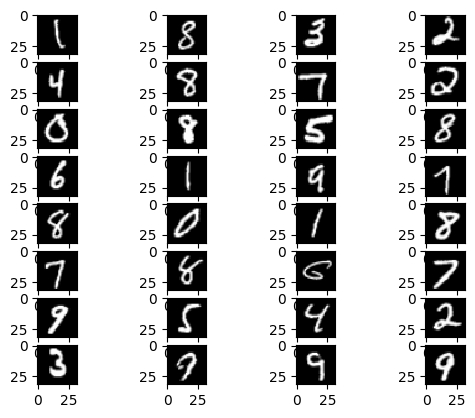

Predicted: "[1 8 2 2 4 9 7 2 0 8 5 8 6 1 4 7 8 0 1 8 7 8 0 7 9 5 4 2 2 7 9 9]"
Actual:    "[1 8 3 2 4 8 7 2 0 8 5 8 6 1 9 7 8 0 1 8 7 8 6 7 9 5 4 2 3 9 9 9]"


In [13]:
import numpy as np
from mindspore import Tensor
import matplotlib.pyplot as plt
import mindspore as ms

# 实例化model类
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy'})
# 加载已经保存的用于测试的模型
param_dict = ms.load_checkpoint("./lenet/lenet-1_1875.ckpt")

# 加载参数到网络中
ms.load_param_into_net(network, param_dict)

#加载测试集
dataset_infer = MnistDataset(save_dir+"/MNIST/test",shuffle=True) 
dataset_infer = datapipe(dataset_infer,BATCH_SIZE,"test")

ds_test = dataset_infer.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

plt.figure()
for i in range(1, 33):
    plt.subplot(8, 4, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
plt.show()

# 使用函数model.predict预测image对应分类
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}"')
print(f'Actual:    "{labels}"')